In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import tqdm
import gc
import os

import numpy as np
import PIL.Image
import torch
import torchvision.models.detection.faster_rcnn as frcnn
import torchvision.transforms as T
import tqdm
from maskrcnn.lizard_dataset import LizardDataset
from maskrcnn.dataset import ImageDataset as ConsepDataset

from maskrcnn.validate import get_instance_match

to_pil_image = T.ToPILImage()

plt.rcParams['figure.figsize'] = (9, 9)

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = frcnn.fasterrcnn_resnet50_fpn(pretrained=True)
# set the number of classes to 6
# see https://pytorch.org/vision/stable/_modules/torchvision/models/detection/faster_rcnn.html#fasterrcnn_resnet50_fpn
model.roi_heads.box_predictor = frcnn.FastRCNNPredictor(1024, 6)
model.roi_heads.detections_per_img = 1000
model.rpn.head = frcnn.RPNHead(
    # number of channels in the input feature map
    256,
    # number of anchors
    3,
    # number of intermediate convolutional layers to use
    conv_depth=2
)
angen = frcnn.AnchorGenerator(
#     sizes=((16,), (32,), (64,)),
#     aspect_ratios=((0.5, 1.0, 2.0), (0.5, 1.0, 2.0)),
    sizes = ((16,), (24,), (32,), (40,), (48,)),
    aspect_ratios=((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
)

model.rpn.anchor_generator = angen
model.to(device)
print(angen.num_anchors_per_location())
None
# show_model_sample(model, consep_dataset, 100)

/dartfs-hpc/rc/home/x/f006jnx/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/dartfs-hpc/rc/home/x/f006jnx/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[3, 3, 3, 3, 3]


In [247]:
# default_anchorgen = frcnn._default_anchorgen()
# print(default_anchorgen.sizes)
# print(default_anchorgen.aspect_ratios)

# model.load_state_dict(torch.load("maskrcnn/joint_lizard_consep_models/model_20.pt"))
# model.eval()

In [4]:
def standard_scaler_per_channel(image: torch.Tensor):
    return (image - image.mean(dim=(-2, -1), keepdim=True)) / image.std(dim=(-2, -1), keepdim=True)

def standard_scaler(image: torch.Tensor):
    return (image - image.mean()) / image.std()

def draw_label(image: PIL.Image.Image, label: dict):
    import PIL.ImageDraw

    colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange']
    imagedraw = PIL.ImageDraw.Draw(image)
    for clas, (x1, y1, x2, y2) in zip(label['labels'], label['boxes']):
        imagedraw.rectangle((x1, y1, x2, y2), outline=colors[clas - 1])

def test_draw_label():
    i0 = I(image_paths[0])
    l0 = L(label_paths[0])

    draw_label(i0, l0)

    i0.save("test.png")

def label_from_pt(pt_label):
    return {
        "class": (pt_label['labels'].detach().cpu().numpy() + 1)[..., None],
        # y1, y2, x1, x2 from x1, y1, x2, y2
        "bbox": pt_label['boxes'].detach().cpu().numpy()[:, [1, 3, 0, 2]],
    }

def show_model_sample(model, dataset, index):
    model.eval()
    images, labels = dataset[index]
    label = labels[0]
    result = model(images)[0]
    
    pil_image_gt = to_pil_image(images[0])
    pil_image_pred = to_pil_image(images[0])
    
    valid_indexes = result['scores'] > 0 # .2
    
#     print(valid_indexes.sum())
    
#     plt.subplot(1, 2, 1)
    draw_label(pil_image_gt, {
        'labels': label['labels'],
        'boxes': label['boxes'][:, [2, 3, 0, 1]]
    })
    plt.imshow(pil_image_gt)
    plt.show()
    
#     plt.subplot(1, 2, 2)
    draw_label(pil_image_pred, {
        'labels': result['labels'][valid_indexes],
        'boxes': result['boxes'][valid_indexes]
    })
    plt.imshow(pil_image_pred)
    plt.show()
    
train_transforms = T.Compose([
    # T.ToTensor(),
    standard_scaler_per_channel,
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
])

test_transforms = T.Compose([
    # T.ToTensor(),
    standard_scaler_per_channel,
])

In [14]:
LIZARD_DIR = "./input_data/colon_nuclei_lizard"
lizard_dataset = LizardDataset(LIZARD_DIR, include_mask=False)

dataset = lizard_dataset

np.random.seed(2)

permutation = np.random.permutation(len(dataset))
train_permutation = permutation[:int(len(permutation) * 0.8)]
test_permutation = permutation[int(len(permutation) * 0.8):]

train_set = torch.utils.data.Subset(dataset, train_permutation)
test_set = torch.utils.data.Subset(dataset, test_permutation)

print(gc.collect(), torch.cuda.empty_cache())

2268 None


In [18]:
def train(model):
    model.train()
    optim = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-4)
#     lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR()
    
    for epoch in range(100):
        with tqdm.tqdm(train_set, desc='Training epoch ' + str(epoch)) as pbar:
            loss_totals = {}
            n = 0
            for (images_pt, labels_pt) in pbar:
                for (image_pt, label_pt) in zip(images_pt, labels_pt):
                    losses = model([image_pt], [label_pt])
                    loss = sum(loss for loss in losses.values())
                    optim.zero_grad()
                    loss.backward()
                    optim.step()

                n += 1
                for k, v in losses.items():
                    loss_totals[k] = loss_totals.get(k, 0) + v.item()
                loss_totals['total'] = loss_totals.get('total', 0) + loss.item()
                pbar.set_postfix(**{k: v / n for k, v in loss_totals.items()})

                torch.cuda.empty_cache()
                gc.collect()
        
                if (n + 1) % 150 == 0:
                    show_model_sample(model, test_set, 0)
                    model.train()
    
        with tqdm.tqdm(test_set, desc='Validation') as pbar:
            loss_totals = {}
            n = 0
            for (images_pt, labels_pt) in pbar:
                for (image_pt, label_pt) in zip(images_pt, labels_pt):
                    with torch.no_grad():
                        losses = model([image_pt], [label_pt])
                        loss = sum(loss for loss in losses.values())

                n += 1
                for k, v in losses.items():
                    loss_totals[k] = loss_totals.get(k, 0) + v.item()
                loss_totals['total'] = loss_totals.get('total', 0) + loss.item()
                pbar.set_postfix(**{k: v / n for k, v in loss_totals.items()})

                torch.cuda.empty_cache()
                gc.collect()
        
        if (epoch + 1) % 5 == 0:
            torch.save(model.state_dict(), f"lizard_only_fasterrcnn_model_{epoch + 1}.pt")


In [10]:
import maskrcnn.model

model_maskrcnn = maskrcnn.model.create_maskrcnn(weights='MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT', num_classes=6)
model_maskrcnn.cuda()
None

Training epoch 0:  78%|███████▊  | 148/190 [02:10<00:40,  1.04it/s, loss_box_reg=0.0231, loss_classifier=0.46, loss_objectness=0.409, loss_rpn_box_reg=48.5, total=49.4] 

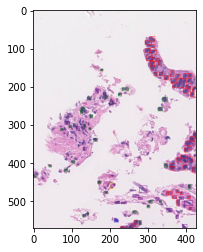

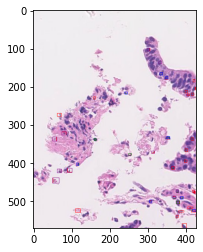

Training epoch 1:  78%|███████▊  | 148/190 [01:24<00:25,  1.64it/s, loss_box_reg=0.0241, loss_classifier=0.39, loss_objectness=0.343, loss_rpn_box_reg=37.4, total=38.2] 

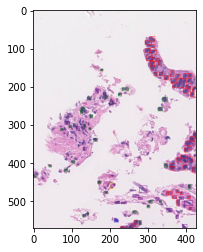

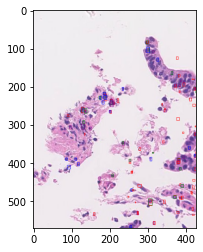

Training epoch 2:  78%|███████▊  | 148/190 [01:24<00:25,  1.64it/s, loss_box_reg=0.0196, loss_classifier=0.381, loss_objectness=0.34, loss_rpn_box_reg=33.9, total=34.6] 

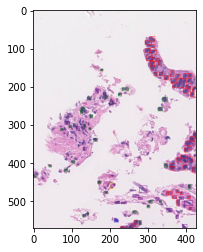

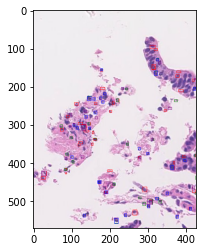

Training epoch 3:  78%|███████▊  | 148/190 [01:24<00:25,  1.64it/s, loss_box_reg=0.0213, loss_classifier=0.378, loss_objectness=0.333, loss_rpn_box_reg=32.5, total=33.3]

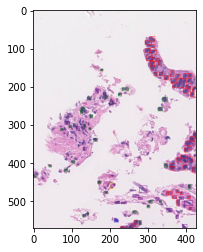

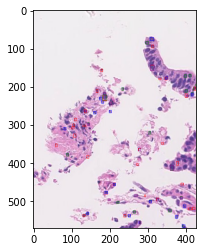

Training epoch 4:   9%|▉         | 18/190 [00:10<01:38,  1.74it/s, loss_box_reg=0.0173, loss_classifier=0.369, loss_objectness=0.284, loss_rpn_box_reg=31.7, total=32.4]


KeyboardInterrupt: 

In [21]:
train(model)

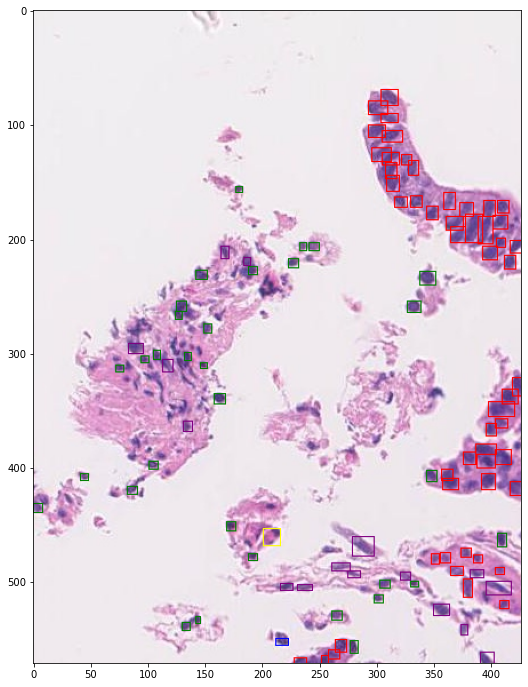

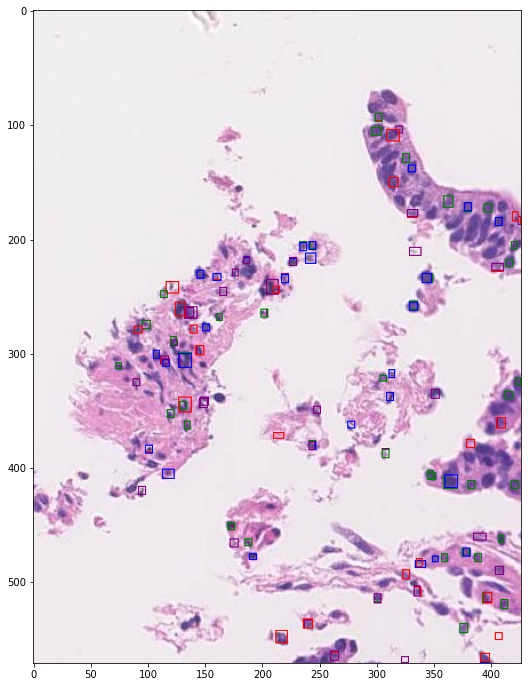

In [24]:
plt.rcParams['figure.figsize'] = [12, 12]

# show_model_sample(model, train_set, 2)
# to_pil_image(train_set[2][0][0])
show_model_sample(model, lizard_dataset, test_permutation[0])
# print(concat_dataset[train_permutation[2]])
# train_permutation[2]

torch.save(model.state_dict(), 'lizard_frcnn_epoch_4.pt')


In [50]:
tmp_boxes = lizard_dataset[test_permutation[4]][1][0]['boxes']
(tmp_boxes[:, [2, 3]] - tmp_boxes[:, [0, 1]]).median(dim=0)

torch.return_types.median(
values=tensor([15, 13], device='cuda:0', dtype=torch.int32),
indices=tensor([ 96, 101], device='cuda:0'))

In [51]:
import detectron2

In [102]:
def validater():
    num_classes = 6

    total_detected_per_class, total_true_per_class, total_matched_per_class = np.zeros((3, num_classes))

    model.eval()
    predictions = []
    labels = []
    with tqdm.tqdm(test_set, desc='Validation') as pbar:
        for (images_pt, labels_pt) in pbar:
            for (image_pt, label_pt) in zip(images_pt, labels_pt):
                with torch.no_grad():
                    prediction = model([image_pt])[0]

                predictions.append(prediction)
                labels.append(label_pt)

                # Draw the prediction
                image_pil = to_pil_image(image_pt)
                draw_label(image_pil, label_from_pt(prediction))
                image_pil.save("Lizard_Model_Prediction.png")
                return

                stats = get_instance_match(prediction, label_pt, num_classes)
                total_detected_per_class += stats[0]
                total_true_per_class += stats[1]
                total_matched_per_class += stats[2]
            
            torch.cuda.empty_cache()
            gc.collect()

    print(total_detected_per_class)
    print(total_true_per_class)
    print(total_matched_per_class)
            
    precision = total_matched_per_class / total_detected_per_class
    recall = total_matched_per_class / total_true_per_class

    result = {"precision": precision, "recall": recall}

    print(result)

    return result